In [1]:
import mlflow
import boto3
import awscli

In [2]:
mlflow.set_tracking_uri("http://ec2-3-107-229-149.ap-southeast-2.compute.amazonaws.com:5000/")

In [3]:
mlflow.set_experiment("Handling Imbalanced Data")

2025/12/15 10:51:42 INFO mlflow.tracking.fluent: Experiment with name 'Handling Imbalanced Data' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://sentiment-analysis-bucket-alqud/mlflow-artifacts/5', creation_time=1765756304566, experiment_id='5', last_update_time=1765756304566, lifecycle_stage='active', name='Handling Imbalanced Data', tags={}>

In [5]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [15]:
df= pd.read_csv("reddit_prepocessing.csv").dropna(subset=["clean_comment"])


2025/12/15 11:17:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Imbalance_class_weights_Randomforest_TFIDF at: http://ec2-3-107-229-149.ap-southeast-2.compute.amazonaws.com:5000/#/experiments/5/runs/5d81d99ed82c46c483b4112609fea4c8
🧪 View experiment at: http://ec2-3-107-229-149.ap-southeast-2.compute.amazonaws.com:5000/#/experiments/5


2025/12/15 11:18:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Imbalance_oversampling_Randomforest_TFIDF at: http://ec2-3-107-229-149.ap-southeast-2.compute.amazonaws.com:5000/#/experiments/5/runs/5589e6e57a8941148d6dfd029e0bccd7
🧪 View experiment at: http://ec2-3-107-229-149.ap-southeast-2.compute.amazonaws.com:5000/#/experiments/5


MlflowException: API request to http://ec2-3-107-229-149.ap-southeast-2.compute.amazonaws.com:5000/api/2.0/mlflow/runs/get failed with exception HTTPConnectionPool(host='ec2-3-107-229-149.ap-southeast-2.compute.amazonaws.com', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/get?run_uuid=eac2de8898644dc6b73e94c0535bf124&run_id=eac2de8898644dc6b73e94c0535bf124 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001FFD7FC8AF0>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

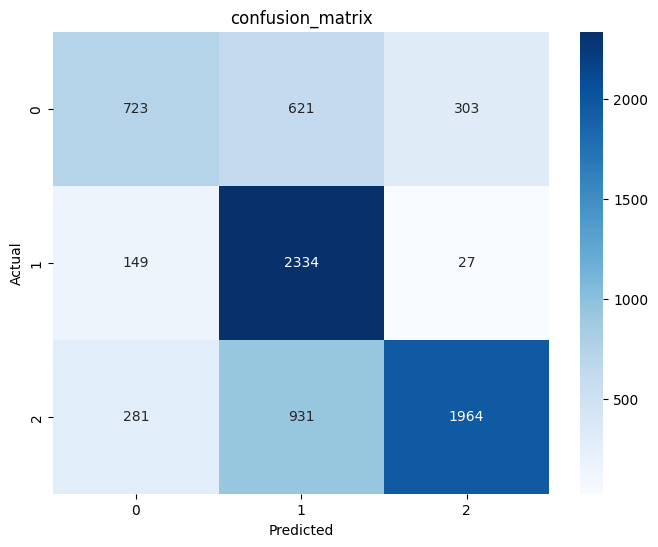

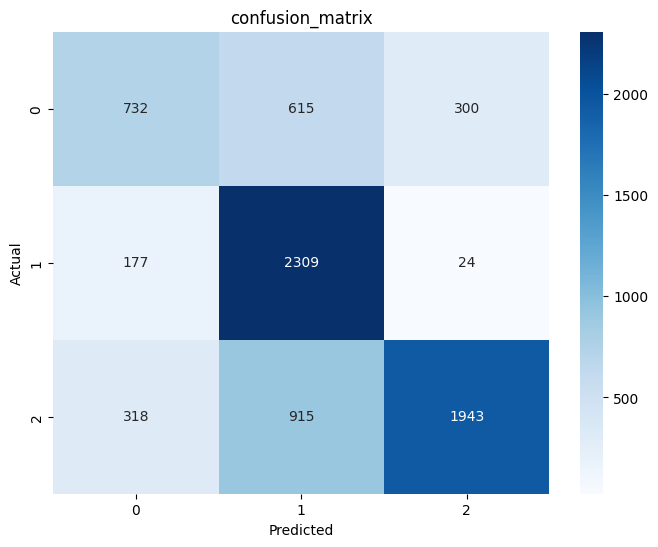

In [16]:
def run_imbalanced_experiment(imbalance_method):
    ngram_range=(1,3)
    max_features=1000

    X_train,X_test,y_train,y_test = train_test_split(df["clean_comment"],df['category'],test_size=0.2,random_state=42)
    vectorizer = TfidfVectorizer(ngram_range=ngram_range,max_features=max_features)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    if imbalance_method =="class_weights":
        class_weight = "balanced"
    else:
        class_weight=None

        if imbalance_method=="oversampling":
            smote = SMOTE(random_state=42)
            X_train,y_train=smote.fit_resample(X_train,y_train)
        elif imbalance_method=="adasyn":
            adasyn = ADASYN(random_state=42)
            X_train,y_train=adasyn.fit_resample(X_train,y_train)
        elif imbalance_method=="undersampling":
            rus = RandomUnderSampler(random_state=42)
            X_train,y_train=rus.fit_resample(X_train,y_train)
        elif imbalance_method=="smote_enn":
            smote_enn = SMOTEENN(random_state=42)
            X_train,y_train=smote_enn.fit_resample(X_train,y_train)
    
    with mlflow.start_run() as run:

        mlflow.set_tag("mlflow.runName",f"Imbalance_{imbalance_method}_Randomforest_TFIDF")
        mlflow.set_tag("experiment_type","imbalance_handling")
        mlflow.set_tag("model_type","RandomForestClassifier")

        mlflow.set_tag("description",f"RandomForestClassifier with TF_IDF trigrams , imbalance handling metgod {imbalance_method}")

        mlflow.log_param("vectorizer_type","TF-IDF")
        mlflow.log_param("ngram_range",ngram_range)
        mlflow.log_param("vectorizer_max_features",max_features)

        n_estimators=200
        max_depth=15

        mlflow.log_param("n_estimators",n_estimators)
        mlflow.log_param("max_depth",max_depth)

        model = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,random_state=42,class_weight=class_weight)
        model.fit(X_train,y_train)

        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test,y_pred)
        mlflow.log_metric("accuracy",accuracy)

        classification_rep = classification_report(y_test,y_pred,output_dict=True)

        for label, metrics in classification_rep.items():
            if isinstance(metrics,dict):
                for metric ,value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}",value)

        conf_matrix = confusion_matrix(y_test,y_pred)
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_matrix,annot=True,fmt="d",cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("confusion_matrix")

        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        

        mlflow.sklearn.log_model(model,f"random_forest_model_tfidf_trigrams_{max_features}")




imbalance_methods = ["class_weights","oversampling" ,"adasyn","undersampling", "smote_enn"]
for method in imbalance_methods:
    run_imbalanced_experiment(method)

        



In [13]:
df.head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1
